# We're going to try fitting a full asymptotic relation to some simulated data

We'll do Gaussian noise cos it makes my life easier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
# import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
        nmax = (numax / deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * deltanu
    
    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, numax, deltanu, alpha, epsilon)
        return f0 + d01
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon)
        return f0 - d02

In [3]:
nmodes = 2   # Two overtones
nbase = 18   # Starting at n = 18
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05     # Data has a frequency spacing of 0.05 microhertz
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value  # Setting a sensible nyquist value
ff = np.arange(fs, nyq, fs)  # Generating the full frequency range

Set the asymptotic parameters

In [4]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.
epsilon_ = 0.
d01_ = deltanu_/2.
d02_ = 6.

Generate the model for the full range

In [5]:
mod = model(ff, n0_, n1_, n2_)

Calculate the predicted mode frequencies

In [6]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
f0_ = mod.f0(init_f)
f1_ = mod.f1(init_f)
f2_ = mod.f2(init_f)

Slice up the data to just be around the mode frequencies

In [7]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [8]:
mod = model(f, n0_, n1_, n2_)

Set up initial guesses for the model parameters

In [9]:
def gaussian(locs, l, numax, Hmax0):
    fwhm = 0.25 * numax
    std = fwhm/2.355

    Vl = [1.0, 1.22, 0.71, 0.14]

    return Hmax0 * Vl[l] * np.exp(-0.5 * (locs - numax)**2 / std**2)

In [10]:
init_m =[f0_,                         # l0 modes
           f1_,                         # l1 modes
           f2_,                         # l2 modes
           np.ones(len(f0_)) * 2.0,     # l0 widths
           np.ones(len(f1_)) * 2.0,     # l1 widths
           np.ones(len(f2_)) * 2.0,     # l2 widths
           np.sqrt(gaussian(f0_, 0, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l0 heights
           np.sqrt(gaussian(f1_, 1, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l1 heights
           np.sqrt(gaussian(f2_, 2, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l2 heights
           1.,       # splitting
           np.pi/4.,                    # inclination angle
           1.                           # background parameters
        ]

# Add on the chisquare 2 dof noise
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

Plot what our data looks like

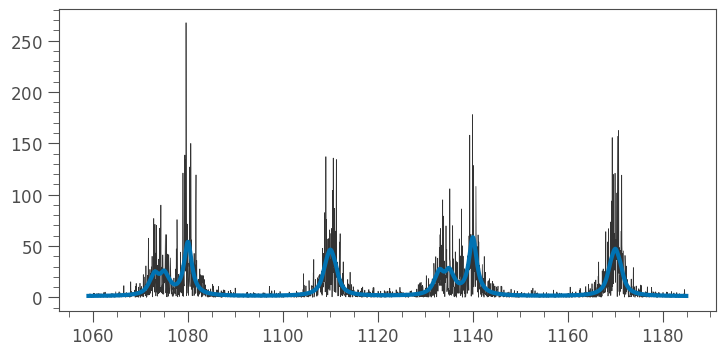

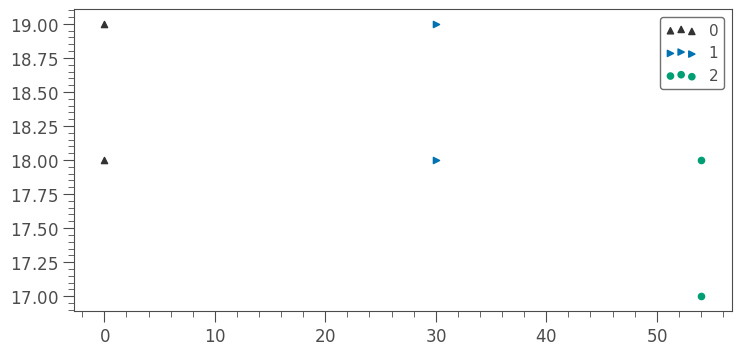

In [11]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0', s=20)
    ax.scatter(f1_%deltanu_, n1_, marker='>',label='1', s=20)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2', s=20)

    ax.legend()
    plt.show()    

# Fitting the model:

In [12]:
pm_model = pm.Model()

with pm_model:   
    #.. whatever you think sensible here
    
    
    # I've left these below for you to use if you want because I trust these parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = pm.Bound(pm.Normal, lower=0.)('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

NameError: name 'f0' is not defined